In [1]:
import sys
sys.path.insert(0, '..\\..\\..\\frxas.py')
import glob
import re

import numpy as np
import h5py
import matplotlib.pyplot as plt
import lmfit
from lmfit import Parameters, minimize, fit_report

from frxas import hdf5_io
from frxas import models
from frxas import visualization
from frxas.models import save_fit_report, load_fit_report

%reload_ext autoreload
%autoreload 2
# %matplotlib inline

In [2]:
starts = [[4, 199, 2, 3], [6, 149, 6, 0], [2, 99,3]] # [[0,0,0,0],[0,0,0,0],[0,0,0]]
f1 = hdf5_io.get_all_datasets('July18_20201211_processed', harmonic=1, start_indices=starts)

x, data1, ir_avgs, frequencies, gases, sizes = hdf5_io.unpack_data(f1, kind='adj')

colors = ['k', 'r', 'b', 'c']
markers = [(6, 2, 0), 's', '^', 'o']

colors = colors * (len(colors) % len(data1))
markers = markers * (len(colors) % len(data1))

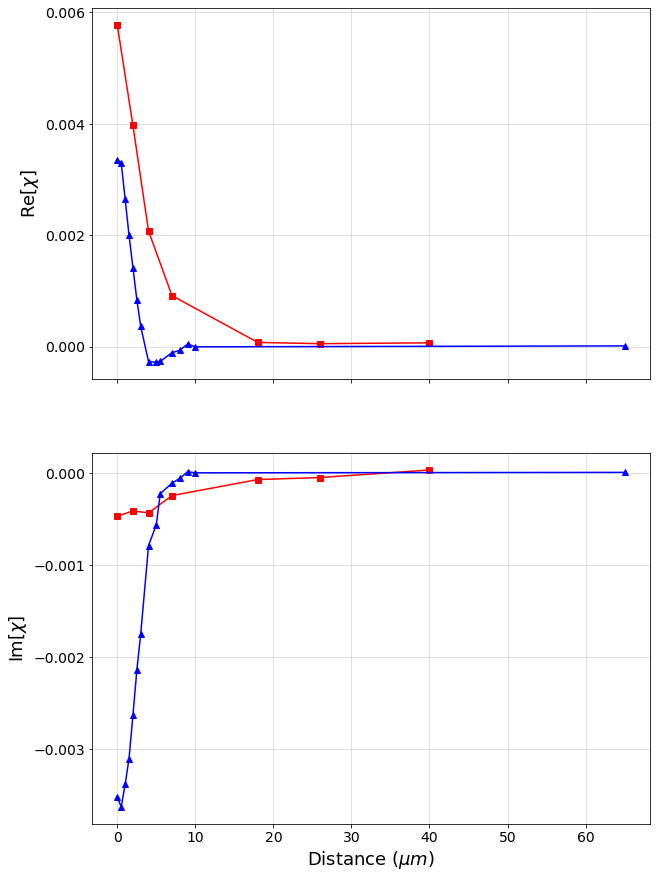

In [4]:
fig, axes = plt.subplots(nrows=2, figsize=(10,15))

# for iy in np.arange(1,sizes[0]):
#     visualization.plot_chi(axes, x[iy], data1[iy], color=colors[iy], marker=markers[iy], ls='-')
# for iy in np.arange(sizes[0]+1, sum(sizes[:2])):
#     visualization.plot_chi(axes, x[iy], data1[iy], color=colors[iy], marker=markers[iy], ls='-')
for iy in np.arange(sum(sizes[:2])+1,sum(sizes)):
    visualization.plot_chi(axes, x[iy], data1[iy], color=colors[iy], marker=markers[iy], ls='-')
# axes[0].set_title('1% $O_2 \; \chi_1$', fontsize=18)
# fig.subplots_adjust(hspace=0.02)

# for ax in axes:
#     ax.set_xlim(460,480)
plt.show()

### Fitting DC data separately to establish ld

In [5]:
dc_data = [data1[0], data1[4], data1[8]]
dc_x = [x[0], x[4], x[8]]

In [6]:
def chi_dc(x, amp=1, ld=10, base=0):
    chi = amp * (np.exp(-x / ld)) + base
    return chi

In [7]:
dc_params = Parameters()

for iy, (data, dum_x) in enumerate(zip(dc_data, dc_x)):
    base_inds =  dum_x > .7 * dum_x[-1]
    est_base = np.mean(data[base_inds]).real
    
    dc_params.add(f'amp_{iy+1}', value=data[0].real - est_base, min=-1, max=1, vary=True)
#     dc_params.add(f'amp_{iy+1}', value=data[0].real, min=-1, max=1, vary=False)
#     dc_params.add(f'amp_{iy+1}', value=-1, vary=False)
#     dc_params[f'amp_{iy+1}'].expr = f'amp_{iy+1} - base_{iy+1}'

    dc_params.add(f'ld_{iy+1}', value=30/(iy+1), min=1e-9, max=100)
    
#     dc_params.add(f'base_{iy+1}', value=est_base, min=-1, max=11)
    dc_params.add(f'base_{iy+1}', value=1e-9, min=-1, max=11)

dc_mini = lmfit.Minimizer(models.objective_fun, dc_params, fcn_args=(dc_x, dc_data, chi_dc))

dc_out = dc_mini.minimize(method='leastsq')

# save_fit_report(f'..\\Fit Reports\\20201211_processed_DC_data_FixAmpNeg.txt', dc_out, starts)
print('\u03A7_red = ', dc_out.redchi)
print(fit_report(dc_out))

Χ_red =  1.8855268895857036e-06
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 51
    # data points      = 744
    # variables        = 9
    chi-square         = 0.00138586
    reduced chi-square = 1.8855e-06
    Akaike info crit   = -9797.94450
    Bayesian info crit = -9756.43613
[[Variables]]
    amp_1:   0.05188052 +/- 4.7064e-04 (0.91%) (init = 0.05332507)
    ld_1:    33.7274363 +/- 0.61852476 (1.83%) (init = 30)
    base_1:  0.00276142 +/- 1.6345e-04 (5.92%) (init = 1e-09)
    amp_2:   0.03957329 +/- 6.2607e-04 (1.58%) (init = 0.04008441)
    ld_2:    17.3600564 +/- 0.48732082 (2.81%) (init = 15)
    base_2:  0.00139985 +/- 1.7378e-04 (12.41%) (init = 1e-09)
    amp_3:   0.02644602 +/- 0.00104411 (3.95%) (init = 0.02444984)
    ld_3:    4.66520884 +/- 0.31617108 (6.78%) (init = 10)
    base_3: -4.8612e-05 +/- 2.0189e-04 (415.31%) (init = 1e-09)
[[Correlations]] (unreported correlations are < 0.100)
    C(ld_1, base_1) = -0.648
    C(ld_2, base_2) =

C:\Users\shadd\Anaconda3\envs\UW\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


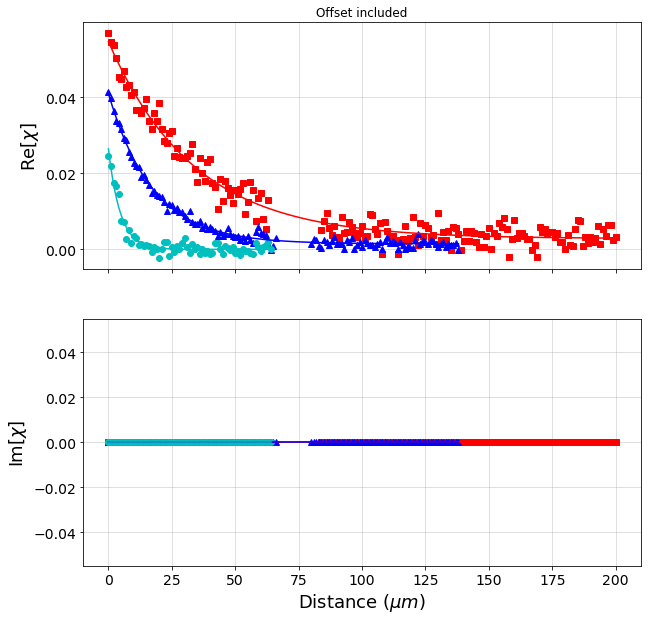

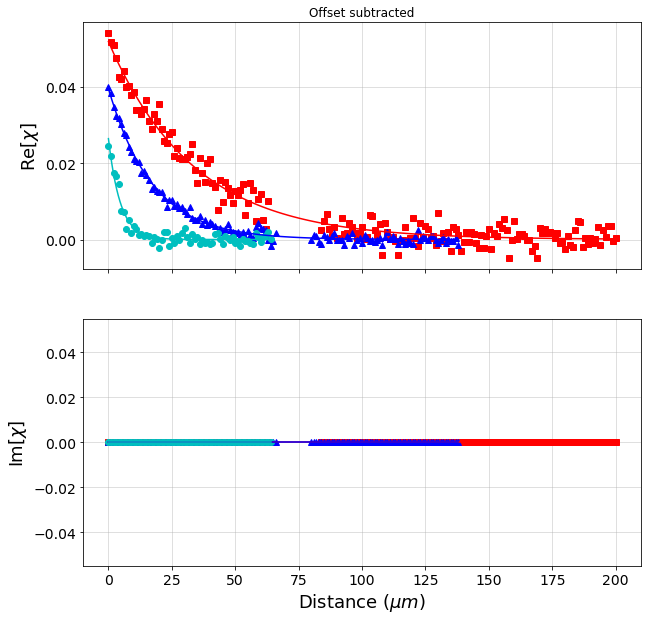

In [8]:
fig, axes = plt.subplots(nrows=2, figsize=(10,10))

for iy in np.arange(0, 3):
    visualization.plot_chi(axes, dc_x[iy], dc_data[iy], color=colors[iy+1],
                           marker=markers[iy+1], ls='',
                           label=f'{gases[(iy+1)*3]} bar O2')
for iy in np.arange(0, 3):
    y = np.linspace(0, dc_x[iy][-1], num=100)
    visualization.plot_chi(axes, y, models.dataset_fun(dc_out.params, iy, y, chi_dc),
                           color=colors[iy+1], marker='')
                           #label=str(frequencies[iy]) + ' Hz')
axes[0].set_title('Offset included')
plt.show()

fig, axes = plt.subplots(nrows=2, figsize=(10,10))

for iy in np.arange(0, 3):
    visualization.plot_chi(axes, dc_x[iy], dc_data[iy] - dc_out.params[f'base_{iy+1}'], color=colors[iy+1],
                           marker=markers[iy+1], ls='',
                           label=f'{gases[(iy+1)*3]} bar O2')
for iy in np.arange(0, 3):
    y = np.linspace(0, dc_x[iy][-1], num=100)
    visualization.plot_chi(axes, y, models.dataset_fun(dc_out.params, iy, y, chi_dc) - dc_out.params[f'base_{iy+1}'],
                           color=colors[iy+1], marker='')
                           #label=str(frequencies[iy]) + ' Hz')
axes[0].set_title('Offset subtracted')
plt.show()

### Fitting AC data separately for tg and gamma

In [76]:
import itertools
ac_data = []
ac_data.append(data1[1:4])
ac_data.append(data1[5:8])
ac_data.append(data1[9:])
ac_data = list(itertools.chain.from_iterable(a for a in ac_data))

ac_x = []
ac_x.append(x[1:4])
ac_x.append(x[5:8])
ac_x.append(x[9:])
ac_x = list(itertools.chain.from_iterable(a for a in ac_x))

ac_freqs = [0.25, 1, 4, 0.25, 1, 5, 0.5, 8]

### Pinning tg, gamma and amp within pO2 to lowest frequency dataset

In [33]:
ac_params = Parameters()
bound_fac = 1.5
est_amps = []
for iy, data in enumerate(ac_data[::3]):
    est_amps.append(-np.abs(data[0]/(1 + .05 * np.sqrt(1 + 1j * 2*np.pi*ac_freqs[iy]))))

for iy, data in enumerate(ac_data):
    est_amp = est_amps[int(iy/3)]
    est_min = est_amp * bound_fac
    est_max = est_amp / bound_fac
    
    ac_params.add(f'amp_{iy+1}', value=est_amp, min=est_min, max=est_max)
    print(f'amp_{iy+1} est_amp: {est_amp} min: {est_min} max: {est_max}')
    
    ac_params.add(f'gammap_{iy+1}', value=0.055, min=1e-9, max=.2)
    
    # setting ld to DC fit result
    ac_params.add(f'ld_{iy+1}', value=dc_out.params[f'ld_{int(iy/3)+1}'].value, vary=False)
    ac_params.add(f'tg_{iy+1}', value=1, min=1e-9, max=10.0)
    ac_params.add(f'f_{iy+1}', value=ac_freqs[iy], vary=False)
    ac_params.add(f'L_{iy+1}', value=6e-1, vary=False)

# params pinned to F1
ac_params[f'amp_2'].expr = 'amp_1'
ac_params[f'amp_3'].expr = 'amp_1'
ac_params[f'amp_5'].expr = 'amp_4'
ac_params[f'amp_6'].expr = 'amp_4'
ac_params[f'amp_8'].expr = 'amp_7'

ac_params[f'tg_2'].expr = 'tg_1'
ac_params[f'tg_3'].expr = 'tg_1'
ac_params[f'tg_5'].expr = 'tg_4'
ac_params[f'tg_6'].expr = 'tg_4'
ac_params[f'tg_8'].expr = 'tg_7'

ac_params[f'gammap_2'].expr = 'gammap_1'
ac_params[f'gammap_3'].expr = 'gammap_1'
ac_params[f'gammap_5'].expr = 'gammap_4'
ac_params[f'gammap_6'].expr = 'gammap_4'
ac_params[f'gammap_8'].expr = 'gammap_7'

ac_mini = lmfit.Minimizer(models.objective_fun, ac_params, fcn_args=(ac_x, ac_data, models.chi_patterned))

ac_out_F1 = ac_mini.minimize(method='leastsq')

# save_fit_report(f'..\\Fit Reports\\ld_from_DC_FreeAmp_F3_pinned.txt', ac_out, starts)
print('\u03A7_red = ', ac_out_F1.redchi)
print(fit_report(ac_out_F1))

amp_1 est_amp: -0.011536777306513389 min: -0.017305165959770084 max: -0.007691184871008926
amp_2 est_amp: -0.011536777306513389 min: -0.017305165959770084 max: -0.007691184871008926
amp_3 est_amp: -0.011536777306513389 min: -0.017305165959770084 max: -0.007691184871008926
amp_4 est_amp: -0.009955459335400456 min: -0.014933189003100682 max: -0.00663697289026697
amp_5 est_amp: -0.009955459335400456 min: -0.014933189003100682 max: -0.00663697289026697
amp_6 est_amp: -0.009955459335400456 min: -0.014933189003100682 max: -0.00663697289026697
amp_7 est_amp: -0.004850445404196326 min: -0.007275668106294489 max: -0.0032336302694642174
amp_8 est_amp: -0.004850445404196326 min: -0.007275668106294489 max: -0.0032336302694642174
Χ_red =  2.8810823484822997e-07
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 99
    # data points      = 260
    # variables        = 9
    chi-square         = 7.2315e-05
    reduced chi-square = 2.8811e-07
    Akaike info crit   = -3906.74

### Pinning tg, gamma and amp within pO2 to middle frequency dataset

In [14]:
ac_params = Parameters()
bound_fac = 1.5
est_amps = []
for iy, data in enumerate(ac_data[::3]):
    est_amps.append(-np.abs(data[0]/(1 + .05 * np.sqrt(1 + 1j * 2*np.pi*ac_freqs[iy]))))

for iy, data in enumerate(ac_data):
    est_amp = est_amps[int(iy/3)]
    est_min = est_amp * bound_fac
    est_max = est_amp / bound_fac
    
    ac_params.add(f'amp_{iy+1}', value=est_amp, min=est_min, max=est_max)
    print(f'amp_{iy+1} est_amp: {est_amp} min: {est_min} max: {est_max}')
    
    ac_params.add(f'gammap_{iy+1}', value=0.055, min=1e-9, max=.2)
    
    # setting ld to DC fit result
    ac_params.add(f'ld_{iy+1}', value=dc_out.params[f'ld_{int(iy/3)+1}'].value, vary=False)
    ac_params.add(f'tg_{iy+1}', value=1, min=1e-9, max=10.0)
    ac_params.add(f'f_{iy+1}', value=ac_freqs[iy], vary=False)
    ac_params.add(f'L_{iy+1}', value=6e-1, vary=False)


# params pinned to F2
ac_params[f'amp_1'].expr = 'amp_2'
ac_params[f'amp_3'].expr = 'amp_2'
ac_params[f'amp_4'].expr = 'amp_5'
ac_params[f'amp_6'].expr = 'amp_5'
ac_params[f'amp_7'].expr = 'amp_8'

ac_params[f'tg_1'].expr = 'tg_2'
ac_params[f'tg_3'].expr = 'tg_2'
ac_params[f'tg_4'].expr = 'tg_5'
ac_params[f'tg_6'].expr = 'tg_5'
ac_params[f'tg_7'].expr = 'tg_8'

ac_params[f'gammap_1'].expr = 'gammap_2'
ac_params[f'gammap_3'].expr = 'gammap_2'
ac_params[f'gammap_4'].expr = 'gammap_5'
ac_params[f'gammap_6'].expr = 'gammap_5'
ac_params[f'gammap_7'].expr = 'gammap_8'

ac_mini = lmfit.Minimizer(models.objective_fun, ac_params, fcn_args=(ac_x, ac_data, models.chi_patterned))

ac_out_F2 = ac_mini.minimize(method='leastsq')

# save_fit_report(f'..\\Fit Reports\\ld_from_DC_FreeAmp_F3_pinned.txt', ac_out, starts)
print('\u03A7_red = ', ac_out_F2.redchi)
print(fit_report(ac_out_F2))

amp_1 est_amp: -0.011536777306513389 min: -0.017305165959770084 max: -0.007691184871008926
amp_2 est_amp: -0.011536777306513389 min: -0.017305165959770084 max: -0.007691184871008926
amp_3 est_amp: -0.011536777306513389 min: -0.017305165959770084 max: -0.007691184871008926
amp_4 est_amp: -0.009955459335400456 min: -0.014933189003100682 max: -0.00663697289026697
amp_5 est_amp: -0.009955459335400456 min: -0.014933189003100682 max: -0.00663697289026697
amp_6 est_amp: -0.009955459335400456 min: -0.014933189003100682 max: -0.00663697289026697
amp_7 est_amp: -0.004850445404196326 min: -0.007275668106294489 max: -0.0032336302694642174
amp_8 est_amp: -0.004850445404196326 min: -0.007275668106294489 max: -0.0032336302694642174
Χ_red =  2.8810823484822997e-07
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 99
    # data points      = 260
    # variables        = 9
    chi-square         = 7.2315e-05
    reduced chi-square = 2.8811e-07
    Akaike info crit   = -3906.74

### Pinning tg, gamma and amp within pO2 to highest frequency dataset

In [16]:
ac_params = Parameters()
bound_fac = 1.5
est_amps = []
for iy, data in enumerate(ac_data[::3]):
    est_amps.append(-np.abs(data[0]/(1 + .05 * np.sqrt(1 + 1j * 2*np.pi*ac_freqs[iy]))))

for iy, data in enumerate(ac_data):
    est_amp = est_amps[int(iy/3)]
    est_min = est_amp * bound_fac
    est_max = est_amp / bound_fac
    
    ac_params.add(f'amp_{iy+1}', value=est_amp, min=est_min, max=est_max)
    print(f'amp_{iy+1} est_amp: {est_amp} min: {est_min} max: {est_max}')
    
    ac_params.add(f'gammap_{iy+1}', value=0.055, min=1e-9, max=.2)
    
    # setting ld to DC fit result
    ac_params.add(f'ld_{iy+1}', value=dc_out.params[f'ld_{int(iy/3)+1}'].value, vary=False)
    ac_params.add(f'tg_{iy+1}', value=1, min=1e-9, max=10.0)
    ac_params.add(f'f_{iy+1}', value=ac_freqs[iy], vary=False)
    ac_params.add(f'L_{iy+1}', value=6e-1, vary=False)


## params pinned to F3
ac_params[f'amp_1'].expr = 'amp_3'
ac_params[f'amp_2'].expr = 'amp_3'
ac_params[f'amp_4'].expr = 'amp_6'
ac_params[f'amp_5'].expr = 'amp_6'
ac_params[f'amp_7'].expr = 'amp_8'

ac_params[f'tg_1'].expr = 'tg_3'
ac_params[f'tg_2'].expr = 'tg_3'
ac_params[f'tg_4'].expr = 'tg_6'
ac_params[f'tg_5'].expr = 'tg_6'
ac_params[f'tg_7'].expr = 'tg_8'

ac_params[f'gammap_1'].expr = 'gammap_3'
ac_params[f'gammap_2'].expr = 'gammap_3'
ac_params[f'gammap_4'].expr = 'gammap_6'
ac_params[f'gammap_5'].expr = 'gammap_6'
ac_params[f'gammap_7'].expr = 'gammap_8'

ac_mini = lmfit.Minimizer(models.objective_fun, ac_params, fcn_args=(ac_x, ac_data, models.chi_patterned))

ac_out_F3 = ac_mini.minimize(method='leastsq')

# save_fit_report(f'..\\Fit Reports\\ld_from_DC_FreeAmp_F3_pinned.txt', ac_out, starts)
print('\u03A7_red = ', ac_out_F3.redchi)
print(fit_report(ac_out_F3))

amp_1 est_amp: -0.011536777306513389 min: -0.017305165959770084 max: -0.007691184871008926
amp_2 est_amp: -0.011536777306513389 min: -0.017305165959770084 max: -0.007691184871008926
amp_3 est_amp: -0.011536777306513389 min: -0.017305165959770084 max: -0.007691184871008926
amp_4 est_amp: -0.009955459335400456 min: -0.014933189003100682 max: -0.00663697289026697
amp_5 est_amp: -0.009955459335400456 min: -0.014933189003100682 max: -0.00663697289026697
amp_6 est_amp: -0.009955459335400456 min: -0.014933189003100682 max: -0.00663697289026697
amp_7 est_amp: -0.004850445404196326 min: -0.007275668106294489 max: -0.0032336302694642174
amp_8 est_amp: -0.004850445404196326 min: -0.007275668106294489 max: -0.0032336302694642174
Χ_red =  2.8810823484822997e-07
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 99
    # data points      = 260
    # variables        = 9
    chi-square         = 7.2315e-05
    reduced chi-square = 2.8811e-07
    Akaike info crit   = -3906.74

In [31]:
# Check if all parameters are the same
for param in ac_out_F1.params:
    if ac_out_F1.params[param] != ac_out_F2.params[param]:
        print(f'F1 != F2 {param}')
    elif ac_out_F1.params[param] != ac_out_F3.params[param]:
        print(f'F1 != F3 {param}')
    elif ac_out_F2.params[param] != ac_out_F3.params[param]:
        print(f'F2 != F3 {param}')

## So fitting results do not deppend on which dataset within a pO2 is used for pinning. Now we'll look at impact of using different amplitudes for datasets within a gas condition

In [78]:
ac_params = Parameters()
bound_fac = 1.5
est_amps = []
for iy, data in enumerate(ac_data[::3]):
    est_amps.append(-np.abs(data[0]/(1 + .05 * np.sqrt(1 + 1j * 2*np.pi*ac_freqs[iy]))))

for iy, data in enumerate(ac_data):
    est_amp = est_amps[int(iy/3)]
    est_min = est_amp * bound_fac
    est_max = est_amp / bound_fac
    
    ac_params.add(f'amp_{iy+1}', value=est_amp, min=est_min, max=est_max)
    print(f'amp_{iy+1} est_amp: {est_amp} min: {est_min} max: {est_max}')

    ac_params.add(f'gammap_{iy+1}', value=0.055, min=1e-9, max=.2)
    
    # setting ld to DC fit result
    ac_params.add(f'ld_{iy+1}', value=dc_out.params[f'ld_{int(iy/3)+1}'].value, vary=False)
    ac_params.add(f'tg_{iy+1}', value=1, min=1e-9, max=10.0)
    ac_params.add(f'f_{iy+1}', value=ac_freqs[iy], vary=False)
    ac_params.add(f'L_{iy+1}', value=6e-1, vary=False)

# params pinned to F1
ac_params[f'tg_2'].expr = 'tg_1'
ac_params[f'tg_3'].expr = 'tg_1'
ac_params[f'tg_5'].expr = 'tg_4'
ac_params[f'tg_6'].expr = 'tg_4'
ac_params[f'tg_8'].expr = 'tg_7'

ac_params[f'gammap_2'].expr = 'gammap_1'
ac_params[f'gammap_3'].expr = 'gammap_1'
ac_params[f'gammap_5'].expr = 'gammap_4'
ac_params[f'gammap_6'].expr = 'gammap_4'
ac_params[f'gammap_8'].expr = 'gammap_7'

ac_mini = lmfit.Minimizer(models.objective_fun, ac_params, fcn_args=(ac_x, ac_data, models.chi_patterned))

ac_out_free_amp = ac_mini.minimize(method='leastsq')

# save_fit_report(f'..\\Fit Reports\\ld_from_DC_FreeAmp_F3_pinned.txt', ac_out, starts)
print('\u03A7_red = ', ac_out_free_amp.redchi)
print(fit_report(ac_out_free_amp))

amp_1 est_amp: -0.011536777306513389 min: -0.017305165959770084 max: -0.007691184871008926
amp_2 est_amp: -0.011536777306513389 min: -0.017305165959770084 max: -0.007691184871008926
amp_3 est_amp: -0.011536777306513389 min: -0.017305165959770084 max: -0.007691184871008926
amp_4 est_amp: -0.009955459335400456 min: -0.014933189003100682 max: -0.00663697289026697
amp_5 est_amp: -0.009955459335400456 min: -0.014933189003100682 max: -0.00663697289026697
amp_6 est_amp: -0.009955459335400456 min: -0.014933189003100682 max: -0.00663697289026697
amp_7 est_amp: -0.004850445404196326 min: -0.007275668106294489 max: -0.0032336302694642174
amp_8 est_amp: -0.004850445404196326 min: -0.007275668106294489 max: -0.0032336302694642174
Χ_red =  2.387356491911927e-07
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 367
    # data points      = 260
    # variables        = 14
    chi-square         = 5.8729e-05
    reduced chi-square = 2.3874e-07
    Akaike info crit   = -3950.8

In [74]:
print(f'BIC \t Free amp: {ac_out_free_amp.bic:.5e} \t Fixed amp: {ac_out_F1.bic:.5e}')

for param in ac_out_F1.params:
    param_pre = param.split('_')[0]
    param_suff = param.split('_')[-1]
    
    if param_pre in ['amp', 'tg', 'gammap'] and param_suff in ['1', '4', '7']:
        print(f'{param} \t Free amp: {ac_out_free_amp.params[param].value:.3e} +/- {ac_out_free_amp.params[param].stderr:.3e} \t Fixed amp: {ac_out_F1.params[param].value:.3e} +/- {ac_out_F1.params[param].stderr:.3e}')

BIC 	 Free amp: -3.90100e+03 	 Fixed amp: -3.87470e+03
amp_1 	 Free amp: -1.299e-02 +/- 2.786e-04 	 Fixed amp: -1.356e-02 +/- 2.529e-04
gammap_1 	 Free amp: 6.567e-02 +/- 7.702e-03 	 Fixed amp: 4.142e-02 +/- 5.988e-03
tg_1 	 Free amp: 2.483e+00 +/- 1.092e-01 	 Fixed amp: 2.619e+00 +/- 1.269e-01
amp_4 	 Free amp: -1.187e-02 +/- 3.308e-04 	 Fixed amp: -1.192e-02 +/- 3.640e-04
gammap_4 	 Free amp: 1.002e-01 +/- 2.145e-02 	 Fixed amp: 1.324e-01 +/- 2.190e-02
tg_4 	 Free amp: 9.718e-01 +/- 6.153e-02 	 Fixed amp: 9.415e-01 +/- 6.313e-02
amp_7 	 Free amp: -6.971e-03 +/- 7.349e-04 	 Fixed amp: -7.276e-03 +/- 2.419e-04
gammap_7 	 Free amp: 2.000e-01 +/- 2.965e-02 	 Fixed amp: 2.000e-01 +/- 3.247e-02
tg_7 	 Free amp: 1.525e-01 +/- 3.069e-02 	 Fixed amp: 1.529e-01 +/- 3.382e-02


## Fitting results do change when the amplitude is fixed vs free within a pO2. Free amplitude has slightly better BIC.
### Check effect of amplitude bounds

In [63]:
ac_params = Parameters()
bound_fac = 1.5
est_amps = []
for iy, data in enumerate(ac_data[::3]):
    est_amps.append(-np.abs(data[0]/(1 + .05 * np.sqrt(1 + 1j * 2*np.pi*ac_freqs[iy]))))

for iy, data in enumerate(ac_data):
    est_amp = est_amps[int(iy/3)]
    est_min = est_amp * bound_fac
    est_max = est_amp / bound_fac
    
    ac_params.add(f'amp_{iy+1}', value=est_amp) #, min=est_min, max=est_max)
    print(f'amp_{iy+1} est_amp: {est_amp} min: {est_min} max: {est_max}')
    
    ac_params.add(f'gammap_{iy+1}', value=0.055, min=1e-9, max=.2)
    
    # setting ld to DC fit result
    ac_params.add(f'ld_{iy+1}', value=dc_out.params[f'ld_{int(iy/3)+1}'].value, vary=False)
    ac_params.add(f'tg_{iy+1}', value=1, min=1e-9, max=10.0)
    ac_params.add(f'f_{iy+1}', value=ac_freqs[iy], vary=False)
    ac_params.add(f'L_{iy+1}', value=6e-1, vary=False)

# params pinned to F1
ac_params[f'amp_2'].expr = 'amp_1'
ac_params[f'amp_3'].expr = 'amp_1'
ac_params[f'amp_5'].expr = 'amp_4'
ac_params[f'amp_6'].expr = 'amp_4'
ac_params[f'amp_8'].expr = 'amp_7'

ac_params[f'tg_2'].expr = 'tg_1'
ac_params[f'tg_3'].expr = 'tg_1'
ac_params[f'tg_5'].expr = 'tg_4'
ac_params[f'tg_6'].expr = 'tg_4'
ac_params[f'tg_8'].expr = 'tg_7'

ac_params[f'gammap_2'].expr = 'gammap_1'
ac_params[f'gammap_3'].expr = 'gammap_1'
ac_params[f'gammap_5'].expr = 'gammap_4'
ac_params[f'gammap_6'].expr = 'gammap_4'
ac_params[f'gammap_8'].expr = 'gammap_7'

ac_mini = lmfit.Minimizer(models.objective_fun, ac_params, fcn_args=(ac_x, ac_data, models.chi_patterned))

ac_out_bounds = ac_mini.minimize(method='leastsq')

# save_fit_report(f'..\\Fit Reports\\ld_from_DC_FreeAmp_F3_pinned.txt', ac_out, starts)
print('\u03A7_red = ', ac_out_bounds.redchi)
print(fit_report(ac_out_bounds))

amp_1 est_amp: -0.011536777306513389 min: -0.11536777306513389 max: -0.001153677730651339
amp_2 est_amp: -0.011536777306513389 min: -0.11536777306513389 max: -0.001153677730651339
amp_3 est_amp: -0.011536777306513389 min: -0.11536777306513389 max: -0.001153677730651339
amp_4 est_amp: -0.009955459335400456 min: -0.09955459335400456 max: -0.0009955459335400456
amp_5 est_amp: -0.009955459335400456 min: -0.09955459335400456 max: -0.0009955459335400456
amp_6 est_amp: -0.009955459335400456 min: -0.09955459335400456 max: -0.0009955459335400456
amp_7 est_amp: -0.004850445404196326 min: -0.048504454041963255 max: -0.00048504454041963256
amp_8 est_amp: -0.004850445404196326 min: -0.048504454041963255 max: -0.00048504454041963256
Χ_red =  2.8700127457749206e-07
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 127
    # data points      = 260
    # variables        = 9
    chi-square         = 7.2037e-05
    reduced chi-square = 2.8700e-07
    Akaike info crit   = -3907

In [66]:
print(f'BIC \t Free bounds: {ac_out_bounds.bic:.5e} \t Fixed amp: {ac_out_F1.bic:.5e}')

for param in ac_out_F1.params:
    param_pre = param.split('_')[0]
    param_suff = param.split('_')[-1]
    
    if param_pre in ['amp', 'tg', 'gammap'] and param_suff in ['1', '4', '7']:
        print(f'{param} \t Free bounds: {ac_out_bounds.params[param].value:.3e} +/- {ac_out_bounds.params[param].stderr:.3e} \t Fixed amp: {ac_out_F1.params[param].value:.3e} +/- {ac_out_F1.params[param].stderr:.3e}')

BIC 	 Free bounds: -3.87570e+03 	 Fixed amp: -3.87470e+03
amp_1 	 Free bounds: -1.356e-02 +/- 2.524e-04 	 Fixed amp: -1.356e-02 +/- 2.529e-04
gammap_1 	 Free bounds: 4.142e-02 +/- 5.976e-03 	 Fixed amp: 4.142e-02 +/- 5.988e-03
tg_1 	 Free bounds: 2.619e+00 +/- 1.267e-01 	 Fixed amp: 2.619e+00 +/- 1.269e-01
amp_4 	 Free bounds: -1.192e-02 +/- 3.633e-04 	 Fixed amp: -1.192e-02 +/- 3.640e-04
gammap_4 	 Free bounds: 1.324e-01 +/- 2.187e-02 	 Fixed amp: 1.324e-01 +/- 2.190e-02
tg_4 	 Free bounds: 9.414e-01 +/- 6.300e-02 	 Fixed amp: 9.415e-01 +/- 6.313e-02
amp_7 	 Free bounds: -7.657e-03 +/- 8.133e-04 	 Fixed amp: -7.276e-03 +/- 2.419e-04
gammap_7 	 Free bounds: 2.000e-01 +/- 1.356e-02 	 Fixed amp: 2.000e-01 +/- 3.247e-02
tg_7 	 Free bounds: 1.613e-01 +/- 3.397e-02 	 Fixed amp: 1.529e-01 +/- 3.382e-02


## Fitting results slightly depend on the amplitude bounds, with no bounds having a slightly better fit based on Bayesian Information Criteria
### Now check effect of this amplitude initial value guess vs using data magnitude at the gate

In [83]:
ac_params = Parameters()
est_amps = []
for iy, data in enumerate(ac_data[::3]):
    est_amps.append(-np.abs(data[0]))

for iy, data in enumerate(ac_data):
    est_amp = est_amps[int(iy/3)]
    
    ac_params.add(f'amp_{iy+1}', value=est_amp)
    print(f'amp_{iy+1} est_amp: {est_amp}')
    
    ac_params.add(f'gammap_{iy+1}', value=0.055, min=1e-9, max=.2)
    
    # setting ld to DC fit result
    ac_params.add(f'ld_{iy+1}', value=dc_out.params[f'ld_{int(iy/3)+1}'].value, vary=False)
    ac_params.add(f'tg_{iy+1}', value=1, min=1e-9, max=10.0)
    ac_params.add(f'f_{iy+1}', value=ac_freqs[iy], vary=False)
    ac_params.add(f'L_{iy+1}', value=6e-1, vary=False)

# params pinned to F1
ac_params[f'amp_2'].expr = 'amp_1'
ac_params[f'amp_3'].expr = 'amp_1'
ac_params[f'amp_5'].expr = 'amp_4'
ac_params[f'amp_6'].expr = 'amp_4'
ac_params[f'amp_8'].expr = 'amp_7'

ac_params[f'tg_2'].expr = 'tg_1'
ac_params[f'tg_3'].expr = 'tg_1'
ac_params[f'tg_5'].expr = 'tg_4'
ac_params[f'tg_6'].expr = 'tg_4'
ac_params[f'tg_8'].expr = 'tg_7'

ac_params[f'gammap_2'].expr = 'gammap_1'
ac_params[f'gammap_3'].expr = 'gammap_1'
ac_params[f'gammap_5'].expr = 'gammap_4'
ac_params[f'gammap_6'].expr = 'gammap_4'
ac_params[f'gammap_8'].expr = 'gammap_7'

ac_mini = lmfit.Minimizer(models.objective_fun, ac_params, fcn_args=(ac_x, ac_data, models.chi_patterned))

ac_out_init = ac_mini.minimize(method='leastsq')

# save_fit_report(f'..\\Fit Reports\\ld_from_DC_FreeAmp_F3_pinned.txt', ac_out, starts)
print('\u03A7_red = ', ac_out_init.redchi)
print(fit_report(ac_out_init))

amp_1 est_amp: -0.012232692869366263
amp_2 est_amp: -0.012232692869366263
amp_3 est_amp: -0.012232692869366263
amp_4 est_amp: -0.01094090233839605
amp_5 est_amp: -0.01094090233839605
amp_6 est_amp: -0.01094090233839605
amp_7 est_amp: -0.00578911059047214
amp_8 est_amp: -0.00578911059047214
Χ_red =  2.870012752451021e-07
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 147
    # data points      = 260
    # variables        = 9
    chi-square         = 7.2037e-05
    reduced chi-square = 2.8700e-07
    Akaike info crit   = -3907.74205
    Bayesian info crit = -3875.69591
[[Variables]]
    amp_1:    -0.01356012 +/- 2.5243e-04 (1.86%) (init = -0.01223269)
    gammap_1:  0.04141887 +/- 0.00597589 (14.43%) (init = 0.055)
    ld_1:      33.72744 (fixed)
    tg_1:      2.61900385 +/- 0.12670274 (4.84%) (init = 1)
    f_1:       0.25 (fixed)
    L_1:       0.6 (fixed)
    amp_2:    -0.01356012 +/- 2.5243e-04 (1.86%) == 'amp_1'
    gammap_2:  0.04141887 +/- 0.0059758

In [84]:
print(f'BIC \t Data initialized: {ac_out_init.bic:.5e} \t Amp Estimated: {ac_out_bounds.bic:.5e}')

for param in ac_out_F1.params:
    param_pre = param.split('_')[0]
    param_suff = param.split('_')[-1]
    
    if param_pre in ['amp', 'tg', 'gammap'] and param_suff in ['1', '4', '7']:
        print(f'{param} \t Data initialized: {ac_out_init.params[param].value:.3e} +/- {ac_out_init.params[param].stderr:.3e} \t Amp Estimated: {ac_out_bounds.params[param].value:.3e} +/- {ac_out_bounds.params[param].stderr:.3e}')

BIC 	 Data initialized: -3.87570e+03 	 Amp Estimated: -3.87570e+03
amp_1 	 Data initialized: -1.356e-02 +/- 2.524e-04 	 Amp Estimated: -1.356e-02 +/- 2.524e-04
gammap_1 	 Data initialized: 4.142e-02 +/- 5.976e-03 	 Amp Estimated: 4.142e-02 +/- 5.976e-03
tg_1 	 Data initialized: 2.619e+00 +/- 1.267e-01 	 Amp Estimated: 2.619e+00 +/- 1.267e-01
amp_4 	 Data initialized: -1.192e-02 +/- 3.633e-04 	 Amp Estimated: -1.192e-02 +/- 3.633e-04
gammap_4 	 Data initialized: 1.324e-01 +/- 2.187e-02 	 Amp Estimated: 1.324e-01 +/- 2.187e-02
tg_4 	 Data initialized: 9.414e-01 +/- 6.300e-02 	 Amp Estimated: 9.414e-01 +/- 6.300e-02
amp_7 	 Data initialized: -7.657e-03 +/- 8.133e-04 	 Amp Estimated: -7.657e-03 +/- 8.133e-04
gammap_7 	 Data initialized: 2.000e-01 +/- 9.237e-02 	 Amp Estimated: 2.000e-01 +/- 1.356e-02
tg_7 	 Data initialized: 1.613e-01 +/- 3.397e-02 	 Amp Estimated: 1.613e-01 +/- 3.397e-02


## Doesn't make a difference.
### Now we'll look at only using 2 of 3 datasets for 1% and 10% gas conditions to see if this explains poor fitting in 100%. First, only use the lowest and middle frequency datasets

In [85]:
import itertools

# Only using lowest and middle frequencies
ac_data = []
ac_data.append(data1[1:3])
ac_data.append(data1[5:7])
ac_data.append(data1[9:])

ac_data = list(itertools.chain.from_iterable(a for a in ac_data))

ac_x = []
ac_x.append(x[1:3])
ac_x.append(x[5:7])
ac_x.append(x[9:])
ac_x = list(itertools.chain.from_iterable(a for a in ac_x))

ac_freqs = [0.25, 1, 0.25, 1, 0.5, 8]

In [89]:
ac_params = Parameters()
bound_fac = 1.5
est_amps = []
for iy, data in enumerate(ac_data[::2]):
    est_amps.append(-np.abs(data[0]/(1 + .05 * np.sqrt(1 + 1j * 2*np.pi*ac_freqs[iy]))))

for iy, data in enumerate(ac_data):
    est_amp = est_amps[int(iy/2)]
    est_min = est_amp * bound_fac
    est_max = est_amp / bound_fac
    
    ac_params.add(f'amp_{iy+1}', value=est_amp, min=est_min, max=est_max)
#     print(f'amp_{iy+1} min: {est_amp*bound_fac} max: {est_amp/bound_fac}')
    print(f'amp_{iy+1} est_amp: {est_amp} min: {est_min} max: {est_max}')
    
    ac_params.add(f'gammap_{iy+1}', value=0.055, min=1e-9, max=.2)
    # setting ld to DC fit result
    ac_params.add(f'ld_{iy+1}', value=dc_out.params[f'ld_{int(iy/2)+1}'].value, vary=False)
    ac_params.add(f'tg_{iy+1}', value=1, min=1e-9, max=10.0)
    ac_params.add(f'f_{iy+1}', value=ac_freqs[iy], vary=False)
    ac_params.add(f'L_{iy+1}', value=6e-1, vary=False)


## params pinned to F1
ac_params[f'amp_2'].expr = 'amp_1'
ac_params[f'amp_4'].expr = 'amp_3'
ac_params[f'amp_6'].expr = 'amp_5'

ac_params[f'tg_2'].expr = 'tg_1'
ac_params[f'tg_4'].expr = 'tg_3'
ac_params[f'tg_6'].expr = 'tg_5'

ac_params[f'gammap_2'].expr = 'gammap_1'
ac_params[f'gammap_4'].expr = 'gammap_3'
ac_params[f'gammap_6'].expr = 'gammap_5'


ac_mini = lmfit.Minimizer(models.objective_fun, ac_params, fcn_args=(ac_x, ac_data, models.chi_patterned))

ac_out_F1_2 = ac_mini.minimize(method='leastsq')

# save_fit_report(f'..\\Fit Reports\\ld_from_DC_FreeAmp_F3_pinned.txt', ac_out, starts)
print('\u03A7_red = ', ac_out_F1_2.redchi)
print(fit_report(ac_out_F1_2))

amp_1 est_amp: -0.011536777306513389 min: -0.017305165959770084 max: -0.007691184871008926
amp_2 est_amp: -0.011536777306513389 min: -0.017305165959770084 max: -0.007691184871008926
amp_3 est_amp: -0.009955459335400456 min: -0.014933189003100682 max: -0.00663697289026697
amp_4 est_amp: -0.009955459335400456 min: -0.014933189003100682 max: -0.00663697289026697
amp_5 est_amp: -0.005459769193773224 min: -0.008189653790659836 max: -0.0036398461291821493
amp_6 est_amp: -0.005459769193773224 min: -0.008189653790659836 max: -0.0036398461291821493
Χ_red =  1.7697464565758555e-07
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 148
    # data points      = 198
    # variables        = 9
    chi-square         = 3.3448e-05
    reduced chi-square = 1.7697e-07
    Akaike info crit   = -3069.56832
    Bayesian info crit = -3039.97391
[[Variables]]
    amp_1:    -0.01283665 +/- 2.1893e-04 (1.71%) (init = -0.01153678)
    gammap_1:  0.01897321 +/- 0.00599307 (31.59%) (init

In [108]:
print(f'BIC \t Low + Mid Freqs: {ac_out_F1_2.bic:.5e} \t Full Dataset: {ac_out_F1.bic:.5e}')

# First list for truncated AC data, second list for full datasets
for iy1, iy2 in zip([1, 3, 5], [1, 4, 7]):
    
    
    for param_pre in ['amp', 'tg', 'gammap']:
        param1 = f'{param_pre}_{iy1}'
        param2 = f'{param_pre}_{iy2}'
        print(f'{param1} \t Low + Mid Freqs: {ac_out_F1_2.params[param1].value:.3e} +/- {ac_out_F1_2.params[param1].stderr:.3e} \t Full Dataset {param2}: {ac_out_F1.params[param2].value:.3e} +/- {ac_out_F1.params[param2].stderr:.3e}')

BIC 	 Low + Mid Freqs: -3.03997e+03 	 Full Dataset: -3.87470e+03
amp_1 	 Low + Mid Freqs: -1.284e-02 +/- 2.189e-04 	 Full Dataset amp_1: -1.356e-02 +/- 2.529e-04
tg_1 	 Low + Mid Freqs: 3.162e+00 +/- 1.563e-01 	 Full Dataset tg_1: 2.619e+00 +/- 1.269e-01
gammap_1 	 Low + Mid Freqs: 1.897e-02 +/- 5.993e-03 	 Full Dataset gammap_1: 4.142e-02 +/- 5.988e-03
amp_3 	 Low + Mid Freqs: -1.074e-02 +/- 2.465e-04 	 Full Dataset amp_4: -1.192e-02 +/- 3.640e-04
tg_3 	 Low + Mid Freqs: 1.097e+00 +/- 6.314e-02 	 Full Dataset tg_4: 9.415e-01 +/- 6.313e-02
gammap_3 	 Low + Mid Freqs: 3.503e-02 +/- 1.461e-02 	 Full Dataset gammap_4: 1.324e-01 +/- 2.190e-02
amp_5 	 Low + Mid Freqs: -7.657e-03 +/- 6.390e-04 	 Full Dataset amp_7: -7.276e-03 +/- 2.419e-04
tg_5 	 Low + Mid Freqs: 1.613e-01 +/- 2.668e-02 	 Full Dataset tg_7: 1.529e-01 +/- 3.382e-02
gammap_5 	 Low + Mid Freqs: 2.000e-01 +/- 7.317e-02 	 Full Dataset gammap_7: 2.000e-01 +/- 3.247e-02


# Biggest differences are 1% O2 tg, and gammas but other parameters mostly unchanged
## Now only use the lowest and highest frequency datasets

In [103]:
# Only using lowest and highest frequencies
ac_data = []
ac_data.append([data1[1], data1[3]])
ac_data.append([data1[5], data1[7]])
ac_data.append(data1[9:])

ac_data = list(itertools.chain.from_iterable(a for a in ac_data))

ac_x = []
ac_x.append([x[1], x[3]])
ac_x.append([x[5], x[7]])
ac_x.append(x[9:])
ac_x = list(itertools.chain.from_iterable(a for a in ac_x))

ac_freqs = [0.25, 4, 0.25, 5, 0.5, 8]

In [104]:
ac_params = Parameters()
bound_fac = 1.5
est_amps = []
for iy, data in enumerate(ac_data[::2]):
    est_amps.append(-np.abs(data[0]/(1 + .05 * np.sqrt(1 + 1j * 2*np.pi*ac_freqs[iy]))))

for iy, data in enumerate(ac_data):
    est_amp = est_amps[int(iy/2)]
    est_min = est_amp * bound_fac
    est_max = est_amp / bound_fac
    
    ac_params.add(f'amp_{iy+1}', value=est_amp, min=est_min, max=est_max)
#     print(f'amp_{iy+1} min: {est_amp*bound_fac} max: {est_amp/bound_fac}')
    print(f'amp_{iy+1} est_amp: {est_amp} min: {est_min} max: {est_max}')
    
    ac_params.add(f'gammap_{iy+1}', value=0.055, min=1e-9, max=.2)
    # setting ld to DC fit result
    ac_params.add(f'ld_{iy+1}', value=dc_out.params[f'ld_{int(iy/2)+1}'].value, vary=False)
    ac_params.add(f'tg_{iy+1}', value=1, min=1e-9, max=10.0)
    ac_params.add(f'f_{iy+1}', value=ac_freqs[iy], vary=False)
    ac_params.add(f'L_{iy+1}', value=6e-1, vary=False)


## params pinned to F1
ac_params[f'amp_2'].expr = 'amp_1'
ac_params[f'amp_4'].expr = 'amp_3'
ac_params[f'amp_6'].expr = 'amp_5'

ac_params[f'tg_2'].expr = 'tg_1'
ac_params[f'tg_4'].expr = 'tg_3'
ac_params[f'tg_6'].expr = 'tg_5'

ac_params[f'gammap_2'].expr = 'gammap_1'
ac_params[f'gammap_4'].expr = 'gammap_3'
ac_params[f'gammap_6'].expr = 'gammap_5'


ac_mini = lmfit.Minimizer(models.objective_fun, ac_params, fcn_args=(ac_x, ac_data, models.chi_patterned))

ac_out_F1_3= ac_mini.minimize(method='leastsq')

# save_fit_report(f'..\\Fit Reports\\ld_from_DC_FreeAmp_F3_pinned.txt', ac_out, starts)
print('\u03A7_red = ', ac_out_F1_3.redchi)
print(fit_report(ac_out_F1_3))

amp_1 est_amp: -0.011536777306513389 min: -0.017305165959770084 max: -0.007691184871008926
amp_2 est_amp: -0.011536777306513389 min: -0.017305165959770084 max: -0.007691184871008926
amp_3 est_amp: -0.009166908912117688 min: -0.013750363368176532 max: -0.006111272608078459
amp_4 est_amp: -0.009166908912117688 min: -0.013750363368176532 max: -0.006111272608078459
amp_5 est_amp: -0.005459769193773224 min: -0.008189653790659836 max: -0.0036398461291821493
amp_6 est_amp: -0.005459769193773224 min: -0.008189653790659836 max: -0.0036398461291821493
Χ_red =  3.1988692222050866e-07
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 120
    # data points      = 194
    # variables        = 9
    chi-square         = 5.9179e-05
    reduced chi-square = 3.1989e-07
    Akaike info crit   = -2892.54332
    Bayesian info crit = -2863.13259
[[Variables]]
    amp_1:    -0.01345042 +/- 3.2412e-04 (2.41%) (init = -0.01153678)
    gammap_1:  0.04456661 +/- 0.00761150 (17.08%) (in

In [113]:
print(f'BIC \t Low + High Freqs: {ac_out_F1_3.bic:.5e} \t Low + Mid Freqs: {ac_out_F1_2.bic:.5e} \t Full Dataset: {ac_out_F1.bic:.5e}')

# First list for truncated AC data, second list for full datasets
for iy1, iy2 in zip([1, 3, 5], [1, 4, 7]):
    
    
    for param_pre in ['amp', 'tg', 'gammap']:
        param1 = f'{param_pre}_{iy1}'
        param2 = f'{param_pre}_{iy2}'

        print(f'{param1} \t Low + High Freqs: {ac_out_F1_3.params[param1].value:.3e} +/- {ac_out_F1_3.params[param1].stderr:.3e} \t'
              f'Low + Mid Freqs: {ac_out_F1_2.params[param1].value:.3e} +/- {ac_out_F1_2.params[param1].stderr:.3e} \t'
              f'Full Dataset {param2}: {ac_out_F1.params[param2].value:.3e} +/- {ac_out_F1.params[param2].stderr:.3e}')

BIC 	 Low + High Freqs: -2.86313e+03 	 Low + Mid Freqs: -3.03997e+03 	 Full Dataset: -3.87470e+03
amp_1 	 Low + High Freqs: -1.345e-02 +/- 3.241e-04 	Low + Mid Freqs: -1.284e-02 +/- 2.189e-04 	Full Dataset amp_1: -1.356e-02 +/- 2.529e-04
tg_1 	 Low + High Freqs: 2.501e+00 +/- 1.486e-01 	Low + Mid Freqs: 3.162e+00 +/- 1.563e-01 	Full Dataset tg_1: 2.619e+00 +/- 1.269e-01
gammap_1 	 Low + High Freqs: 4.457e-02 +/- 7.612e-03 	Low + Mid Freqs: 1.897e-02 +/- 5.993e-03 	Full Dataset gammap_1: 4.142e-02 +/- 5.988e-03
amp_3 	 Low + High Freqs: -1.288e-02 +/- 5.490e-04 	Low + Mid Freqs: -1.074e-02 +/- 2.465e-04 	Full Dataset amp_4: -1.192e-02 +/- 3.640e-04
tg_3 	 Low + High Freqs: 9.076e-01 +/- 8.380e-02 	Low + Mid Freqs: 1.097e+00 +/- 6.314e-02 	Full Dataset tg_4: 9.415e-01 +/- 6.313e-02
gammap_3 	 Low + High Freqs: 1.861e-01 +/- 3.752e-02 	Low + Mid Freqs: 3.503e-02 +/- 1.461e-02 	Full Dataset gammap_4: 1.324e-01 +/- 2.190e-02
amp_5 	 Low + High Freqs: -7.657e-03 +/- 8.587e-04 	Low + Mid Freq

# Seems Full dataset parameters are in between Low + High and Low + Mid parameters
## Now Mid + High frequency datasets

In [110]:
# Only using middle and highest frequencies
ac_data = []
ac_data.append([data1[2], data1[3]])
ac_data.append([data1[6], data1[7]])
ac_data.append(data1[9:])

ac_data = list(itertools.chain.from_iterable(a for a in ac_data))

ac_x = []
ac_x.append([x[2], x[3]])
ac_x.append([x[6], x[7]])
ac_x.append(x[9:])
ac_x = list(itertools.chain.from_iterable(a for a in ac_x))

ac_freqs = [1, 4, 1, 5, 0.5, 8]

In [111]:
ac_params = Parameters()
bound_fac = 1.5
est_amps = []
for iy, data in enumerate(ac_data[::2]):
    est_amps.append(-np.abs(data[0]/(1 + .05 * np.sqrt(1 + 1j * 2*np.pi*ac_freqs[iy]))))

for iy, data in enumerate(ac_data):
    est_amp = est_amps[int(iy/2)]
    est_min = est_amp * bound_fac
    est_max = est_amp / bound_fac
    
    ac_params.add(f'amp_{iy+1}', value=est_amp, min=est_min, max=est_max)
#     print(f'amp_{iy+1} min: {est_amp*bound_fac} max: {est_amp/bound_fac}')
    print(f'amp_{iy+1} est_amp: {est_amp} min: {est_min} max: {est_max}')
    
    ac_params.add(f'gammap_{iy+1}', value=0.055, min=1e-9, max=.2)
    # setting ld to DC fit result
    ac_params.add(f'ld_{iy+1}', value=dc_out.params[f'ld_{int(iy/2)+1}'].value, vary=False)
    ac_params.add(f'tg_{iy+1}', value=1, min=1e-9, max=10.0)
    ac_params.add(f'f_{iy+1}', value=ac_freqs[iy], vary=False)
    ac_params.add(f'L_{iy+1}', value=6e-1, vary=False)


## params pinned to F1
ac_params[f'amp_2'].expr = 'amp_1'
ac_params[f'amp_4'].expr = 'amp_3'
ac_params[f'amp_6'].expr = 'amp_5'

ac_params[f'tg_2'].expr = 'tg_1'
ac_params[f'tg_4'].expr = 'tg_3'
ac_params[f'tg_6'].expr = 'tg_5'

ac_params[f'gammap_2'].expr = 'gammap_1'
ac_params[f'gammap_4'].expr = 'gammap_3'
ac_params[f'gammap_6'].expr = 'gammap_5'


ac_mini = lmfit.Minimizer(models.objective_fun, ac_params, fcn_args=(ac_x, ac_data, models.chi_patterned))

ac_out_F2_3= ac_mini.minimize(method='leastsq')

# save_fit_report(f'..\\Fit Reports\\ld_from_DC_FreeAmp_F3_pinned.txt', ac_out, starts)
print('\u03A7_red = ', ac_out_F2_3.redchi)
print(fit_report(ac_out_F2_3))

amp_1 est_amp: -0.011475351452534175 min: -0.017213027178801264 max: -0.00765023430168945
amp_2 est_amp: -0.011475351452534175 min: -0.017213027178801264 max: -0.00765023430168945
amp_3 est_amp: -0.007703920579152903 min: -0.011555880868729355 max: -0.005135947052768602
amp_4 est_amp: -0.007703920579152903 min: -0.011555880868729355 max: -0.005135947052768602
amp_5 est_amp: -0.005267687553459199 min: -0.007901531330188798 max: -0.0035117917023061323
amp_6 est_amp: -0.005267687553459199 min: -0.007901531330188798 max: -0.0035117917023061323
Χ_red =  3.190221061807856e-07
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 279
    # data points      = 172
    # variables        = 9
    chi-square         = 5.2001e-05
    reduced chi-square = 3.1902e-07
    Akaike info crit   = -2564.02095
    Bayesian info crit = -2535.69350
[[Variables]]
    amp_1:    -0.01491802 +/- 4.2500e-04 (2.85%) (init = -0.01147535)
    gammap_1:  0.06196854 +/- 0.00911639 (14.71%) (init 

In [117]:
print(f'BIC \t Mid + High Freqs: {ac_out_F2_3.bic:.5e} \t Low + High Freqs: {ac_out_F1_3.bic:.5e}'
      f' \t Low + Mid Freqs: {ac_out_F1_2.bic:.5e} \t Full Dataset: {ac_out_F1.bic:.5e}')

# First list for truncated AC data, second list for full datasets
for iy1, iy2 in zip([1, 3, 5], [1, 4, 7]):
    
    
    for param_pre in ['amp', 'tg', 'gammap']:
        param1 = f'{param_pre}_{iy1}'
        param2 = f'{param_pre}_{iy2}'

        print(f'{param1} Mid + High Freqs: {ac_out_F2_3.params[param1].value:.3e} +/- {ac_out_F2_3.params[param1].stderr:.3e}  '
              f'Low + High Freqs: {ac_out_F1_3.params[param1].value:.3e} +/- {ac_out_F1_3.params[param1].stderr:.3e}   '
              f'Low + Mid Freqs: {ac_out_F1_2.params[param1].value:.3e} +/- {ac_out_F1_2.params[param1].stderr:.3e}   '
              f'Full Dataset {param2}: {ac_out_F1.params[param2].value:.3e} +/- {ac_out_F1.params[param2].stderr:.3e}')

BIC 	 Mid + High Freqs: -2.53569e+03 	 Low + High Freqs: -2.86313e+03 	 Low + Mid Freqs: -3.03997e+03 	 Full Dataset: -3.87470e+03
amp_1 Mid + High Freqs: -1.492e-02 +/- 4.250e-04  Low + High Freqs: -1.345e-02 +/- 3.241e-04   Low + Mid Freqs: -1.284e-02 +/- 2.189e-04   Full Dataset amp_1: -1.356e-02 +/- 2.529e-04
tg_1 Mid + High Freqs: 2.349e+00 +/- 1.488e-01  Low + High Freqs: 2.501e+00 +/- 1.486e-01   Low + Mid Freqs: 3.162e+00 +/- 1.563e-01   Full Dataset tg_1: 2.619e+00 +/- 1.269e-01
gammap_1 Mid + High Freqs: 6.197e-02 +/- 9.116e-03  Low + High Freqs: 4.457e-02 +/- 7.612e-03   Low + Mid Freqs: 1.897e-02 +/- 5.993e-03   Full Dataset gammap_1: 4.142e-02 +/- 5.988e-03
amp_3 Mid + High Freqs: -1.145e-02 +/- 6.105e-04  Low + High Freqs: -1.288e-02 +/- 5.490e-04   Low + Mid Freqs: -1.074e-02 +/- 2.465e-04   Full Dataset amp_4: -1.192e-02 +/- 3.640e-04
tg_3 Mid + High Freqs: 8.993e-01 +/- 8.553e-02  Low + High Freqs: 9.076e-01 +/- 8.380e-02   Low + Mid Freqs: 1.097e+00 +/- 6.314e-02   Fu

## Look at BIC from all fitting approaches

In [122]:
outs = {'ac_out_F1': ac_out_F1,
        'ac_out_F2': ac_out_F2,
        'ac_out_F3': ac_out_F3,
        'ac_out_free_amp': ac_out_free_amp,
        'ac_out_bounds': ac_out_bounds,
        'ac_out_init': ac_out_init,
        'ac_out_F1_2': ac_out_F1_2,
        'ac_out_F1_3': ac_out_F1_3,
        'ac_out_F2_3': ac_out_F2_3}

for key, val in outs.items():
    print(key, val.bic)

ac_out_F1 -3874.695024321835
ac_out_F2 -3874.695024321835
ac_out_F3 -3874.695024321835
ac_out_free_amp -3900.9978134352864
ac_out_bounds -3875.695912052258
ac_out_init -3875.695911447457
ac_out_F1_2 -3039.973913001548
ac_out_F1_3 -2863.1325940640954
ac_out_F2_3 -2535.6935005505475


# Leaving amplitdues as a free feeting parameter is the winner here.